# Showcase for ptdalgorithms

Python header:

In [363]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

def plot_graph(gam, constrained=True, size='10'):

    constrained = constrained and 'true' or 'false'
    
    states, sim, ipv = np.array(gam[0]), np.array(gam[1]), np.array(gam[2])

    states = np.array(states)
    states = np.append(states, np.array([[9]*len(ipv)]), axis=0)
    
    # add the missing row and col to SIM
    rates = np.r_[np.c_[sim, -sim.sum(axis=1)], np.zeros((1, len(sim)+1))]
    
    dot = Digraph()
    dot.node('S', 'S')
    dot.node(str(len(states)-1), 'Absorbing')    
    for i in range(0, len(states)-1):
        dot.node(str(i), str(states[i]))
    for i in range(len(ipv)):
        if ipv[i]:
            dot.edge('S', str(i), constraint=constrained, label=str(ipv[i]))
    for i in range(len(states)):
        for j in range(len(states)):
            if i != j and rates[i, j] > 0:
                dot.edge(str(i), str(j), constraint=constrained, label=str(rates[i, j]))
    dot.graph_attr['size'] = size                
    return dot


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R header:

In [364]:
%%R
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (0c1be222) has not changed since last install.
  Use `force = TRUE` to force installation



## Standard coalescent

If you already have the subintensity matrix and initial probability vector:

In [365]:
%%R -o sim -o ipv
sim = matrix(c(-6, 6, 0, 0, 
               0, -3, 1, 2,
               0, 0, -1, 0,
               0, 0, 0, -1), nrow=4, ncol=4, byrow = TRUE)
ipv = c(1, 0, 0, 0)
sim

     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1


In [366]:
%%R 
graph <- matrix_as_graph(ipv, sim)

Note that the state vectors are ofcause undefined (all zero) when constructing the graph this way:

In [367]:
%%R
graph_as_matrix(graph)

$states
     [,1]
[1,]    0
[2,]    0
[3,]    0
[4,]    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0



In [368]:
%%R
dph(0.9, graph)

[1] 0.5362689


If you want to generate the state space:

In [369]:
%%R -o gam -o n -o graph
n <- 4
  
state_vector_length <- n
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  
  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {
      state <- vertex$state
      
      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }
      
      # copy state
      child_state <- state
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1
      
      add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          rate, c(rate)
        )
    }
  }
      
  index <- index + 1
}

# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

gam <- graph_as_matrix(graph)
vertices_length(graph)

[1] 6


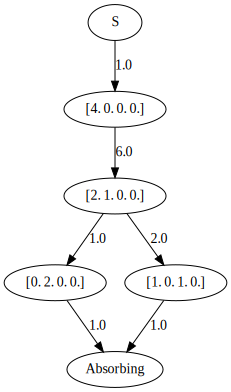

In [370]:
plot_graph(gam)

As matrices:

In [371]:
%%R -o states -o sim
matrices <- graph_as_matrix(graph)
states <- matrices$states
sim <- matrices$SIM
matrices

$states
     [,1] [,2] [,3] [,4]
[1,]    4    0    0    0
[2,]    2    1    0    0
[3,]    0    2    0    0
[4,]    1    0    1    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0



Invert subintensity matrix to get Green matrix:

In [372]:
%%R
U <- -solve(matrices$SIM)
U

          [,1]      [,2]      [,3]      [,4]
[1,] 0.1666667 0.3333333 0.3333333 0.6666667
[2,] 0.0000000 0.3333333 0.3333333 0.6666667
[3,] 0.0000000 0.0000000 1.0000000 0.0000000
[4,] 0.0000000 0.0000000 0.0000000 1.0000000


Compute expectation from matrices:

In [373]:
%%R
matrices$IPV %*% U %*% rep(1, length(matrices$IPV))

     [,1]
[1,]  1.5


Compute moments:

In [374]:
%%R
expectation(graph)

[1] 1.5


INFO: building reward compute graph...


In [375]:
%%R
expected_waiting_time(graph)

[1] 1.500000 1.500000 1.333333 1.000000 1.000000 0.000000


In [376]:
%%R
variance(graph)

[1] 1.138889


In [377]:
%%R
2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph)

[1] 1.138889 1.138889 1.111111 1.000000 1.000000 0.000000


In [378]:
%%R
moments(graph, 4)

[1]  1.500000  3.388889 10.583333 42.907407


Marginal expectations using rewards:

In [379]:
%%R
state_matrix <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
state_matrix

     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    4    2    0    1    0
[2,]    0    0    1    2    0    0
[3,]    0    0    0    0    1    0
[4,]    0    0    0    0    0    1


Rows happens to be our reward vectors. E.g. singleton rewards:

In [380]:
%%R
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
singletons <- rewards[1,]
doubletons <- rewards[2,]
tripletons <- rewards[3,]
singletons

[1] 0 4 2 0 1 0


Expected tripleton branch length:

In [381]:
%%R
expectation(graph, tripletons)

[1] 0.6666667


SFS:

In [382]:
%%R -o sfs
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) expectation(graph, rewards[i,]))
sfs

[1] 2.0000000 1.0000000 0.6666667


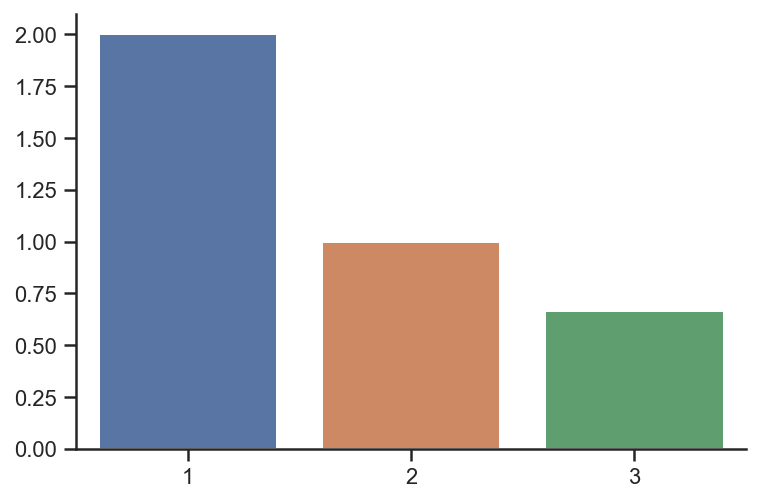

In [383]:
sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
sns.despine()

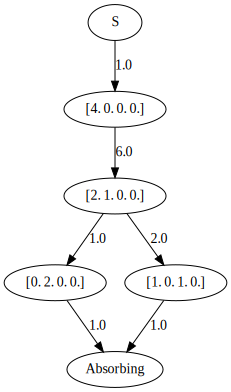

In [384]:


plot_graph(gam)

# Discrete phase-type distribution

In [385]:
%%R -o n -o graph
n <- 14
  
state_vector_length <- n
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  
  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {
      state <- vertex$state
      
      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }
      
      # copy state
      child_state <- state
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1
      
      add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          rate
        )
    }
  }
      
  index <- index + 1
}

vertices_length(graph)

[1] 136


In [386]:
%%R -o sfs


make_discrete <- function(mutation_graph, mutation_rate) {

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    return(rewards)
}

mutation_rate <- 1

mutation_graph <- clone_graph(graph)

rewards <- make_discrete(mutation_graph, mutation_rate)

sfs <- sapply(1:(n-1), function(i) expectation(mutation_graph, rewards[,i]))
sfs

 [1] 2.0000000 1.0000000 0.6666667 0.5000000 0.4000000 0.3333333 0.2857143
 [8] 0.2500000 0.2222222 0.2000000 0.1818182 0.1666667 0.1538462


INFO: building reward compute graph...


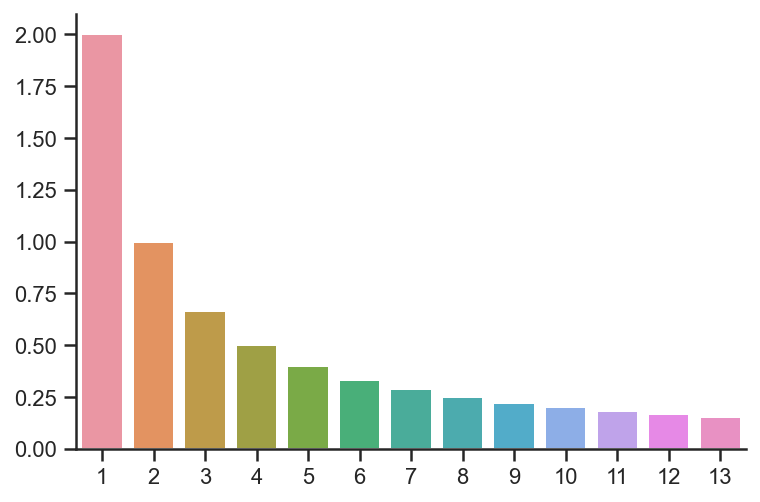

In [387]:
sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
sns.despine()